In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import copy
import pandas as pd

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,1,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,3,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,3,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# Input standardization
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#Output standardization
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#Test set standardization
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_temp_train_input = np.hstack((x_train_input[:, :8], x_train_input[:, -3:-1]))
_temp_train_label = x_train_label

# 将数据转换为 PyTorch 张量
train_input_tensor = torch.tensor(_temp_train_input.astype(np.float32))
train_label_tensor = torch.tensor(_temp_train_label.astype(np.float32))

test_input_tensor = torch.tensor(_temp_test_input.astype(np.float32))
test_label_tensor = torch.tensor(_temp_test_label.astype(np.float32))


# Train Set

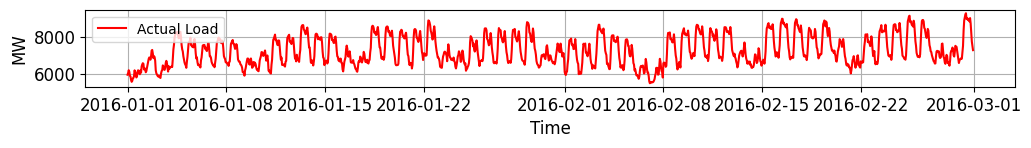

<Figure size 640x480 with 0 Axes>

In [2]:
f = plt.figure(figsize=(12,1))
plt.plot(df_train.iloc[:,0],c='r',label="Actual Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.tight_layout()
plt.show()
# f.savefig("./K-FOld/ALL_TRAIN_SET_OUTPUT.svg",format="svg",dpi=300)
plt.tight_layout()
f.savefig("./K-FOld/ALL_TRAIN_SET_OUTPUT.png",format="png",dpi=300,bbox_inches="tight")

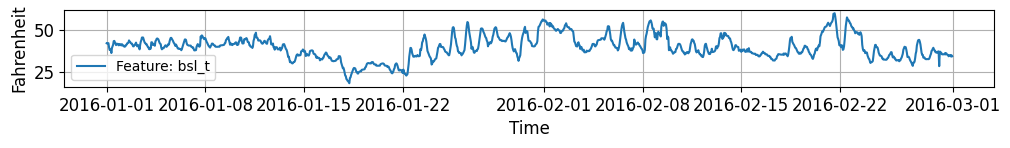

In [3]:
f = plt.figure(figsize=(12,1))
plt.plot(df_train.iloc[:,1],label="Feature: bsl_t")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fahrenheit", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/ALL_TRAIN_SET_INPUT_1.svg",format="svg",dpi=300)
f.savefig("./K-FOld/ALL_TRAIN_SET_INPUT_1.png",format="png",dpi=300,bbox_inches="tight")

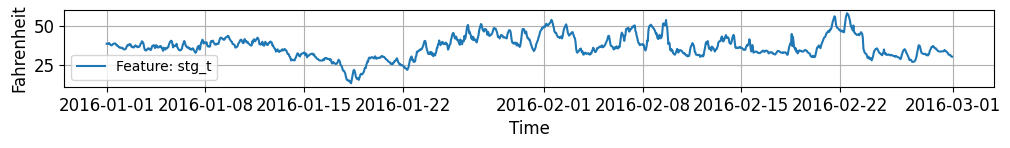

In [4]:
f = plt.figure(figsize=(12,1))
plt.plot(df_train.iloc[:,7],label="Feature: stg_t")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fahrenheit", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/ALL_TRAIN_SET_INPUT_2.svg",format="svg",dpi=300)
f.savefig("./K-FOld/ALL_TRAIN_SET_INPUT_2.png",format="png",dpi=300,bbox_inches="tight")

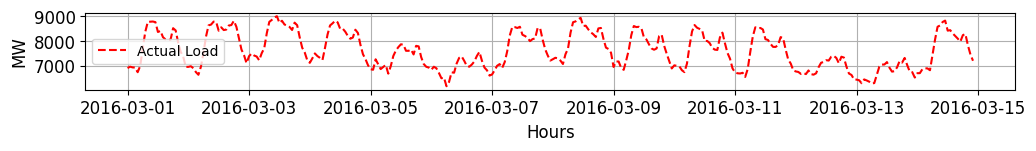

In [5]:
f = plt.figure(figsize=(12,1))
plt.plot(df_test.iloc[:,0],c='r',label="Actual Load", linestyle='--')
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.tight_layout()
plt.show()
# f.savefig("./K-FOld/ALL_TEST_SET_OUTPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/ALL_TEST_SET_OUTPUT.png",format="png",dpi=300,bbox_inches="tight")

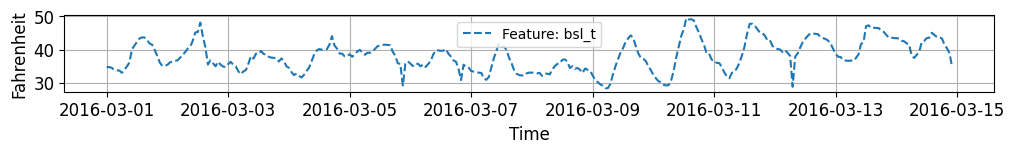

In [6]:
f = plt.figure(figsize=(12,1))
plt.plot(df_test.iloc[:,1],label="Feature: bsl_t", linestyle='--')
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fahrenheit", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/ALL_TEST_SET_INPUT_1.svg",format="svg",dpi=300)
f.savefig("./K-FOld/ALL_TEST_SET_INPUT_1.png",format="png",dpi=300,bbox_inches="tight")

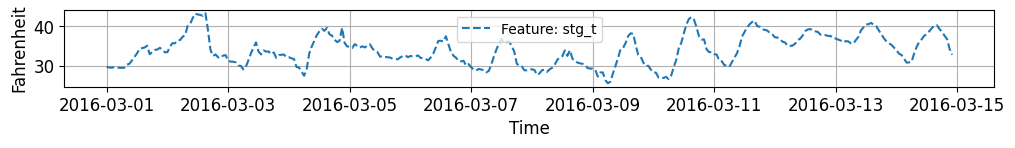

In [7]:
f = plt.figure(figsize=(12,1))
plt.plot(df_test.iloc[:,7],label="Feature: stg_t", linestyle='--')
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fahrenheit", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/ALL_TEST_SET_INPUT_2.svg",format="svg",dpi=300)
f.savefig("./K-FOld/ALL_TEST_SET_INPUT_2.png",format="png",dpi=300,bbox_inches="tight")

# K-Fold

In [8]:
k = 3 # 例如，3折交叉验证
kf = KFold(n_splits=k, shuffle=False)
for fold, (train_index, val_index) in enumerate(kf.split(df_train)):
    train_input_fold = df_train.iloc[train_index,:]
    train_label_fold = df_train.iloc[train_index,0]
    val_input_fold =  df_train.iloc[val_index,:]
    val_label_fold =  df_train.iloc[val_index,0]
    break

## Train set

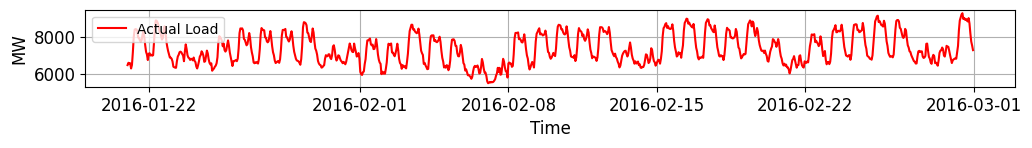

In [9]:
f = plt.figure(figsize=(12,1))
plt.plot(train_input_fold.iloc[:,0],c='r',label="Actual Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/TRAIN_SET_1_OUTPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/TRAIN_SET_1_OUTPUT.png",format="png",dpi=300,bbox_inches="tight")

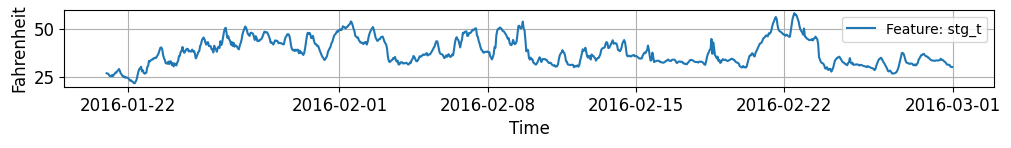

In [10]:
f = plt.figure(figsize=(12,1))
plt.plot(train_input_fold.iloc[:,7],label="Feature: stg_t")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fahrenheit", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/TRAIN_SET_1_INPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/TRAIN_SET_1_INPUT.png",format="png",dpi=300,bbox_inches="tight")

## Val Set

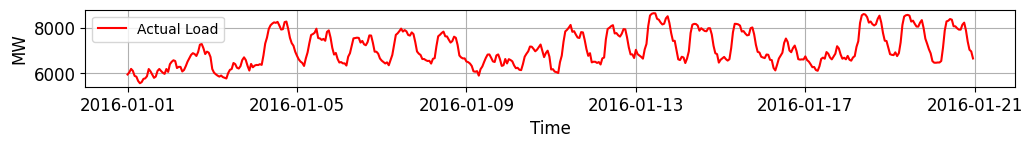

In [11]:
f = plt.figure(figsize=(12,1))
plt.plot(val_input_fold.iloc[:,0],c='r',label="Actual Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/VAL_SET_1_OUTPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/VAL_SET_1_OUTPUT.png",format="png",dpi=300,bbox_inches="tight")

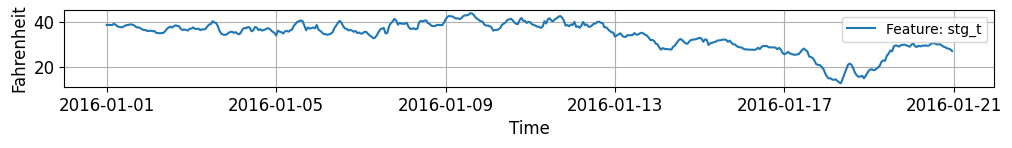

In [12]:
f = plt.figure(figsize=(12,1))
plt.plot(val_input_fold.iloc[:,7],label="Feature: stg_t")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fahrenheit", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/VAL_SET_1_INPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/VAL_SET_1_INPUT.png",format="png",dpi=300,bbox_inches="tight")

In [13]:
k = 3 # 例如，3折交叉验证
kf = KFold(n_splits=k, shuffle=False)
for fold, (train_index, val_index) in enumerate(kf.split(df_train)):
    train_input_fold = df_train.iloc[train_index,:]
    train_label_fold = df_train.iloc[train_index,0]
    val_input_fold =  df_train.iloc[val_index,:]
    val_label_fold =  df_train.iloc[val_index,0]
    if fold == 2:
        break

## Train set

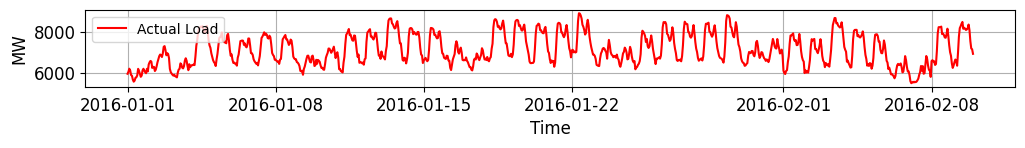

In [14]:
f = plt.figure(figsize=(12,1))
plt.plot(train_input_fold.iloc[:,0],c='r',label="Actual Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/TRAIN_SET_2_OUTPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/TRAIN_SET_2_OUTPUT.png",format="png",dpi=300,bbox_inches="tight")

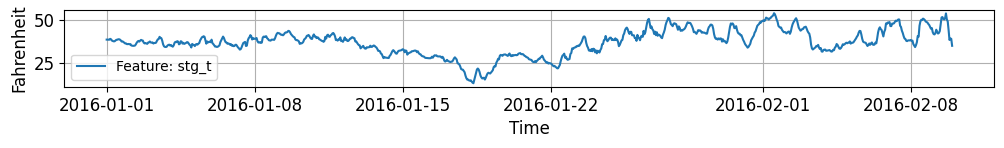

In [15]:
f = plt.figure(figsize=(12,1))
plt.plot(train_input_fold.iloc[:,7],label="Feature: stg_t")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fahrenheit", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# f.savefig("./K-FOld/TRAIN_SET_2_INPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/TRAIN_SET_2_INPUT.png",format="png",dpi=300,bbox_inches="tight")

## Val Set

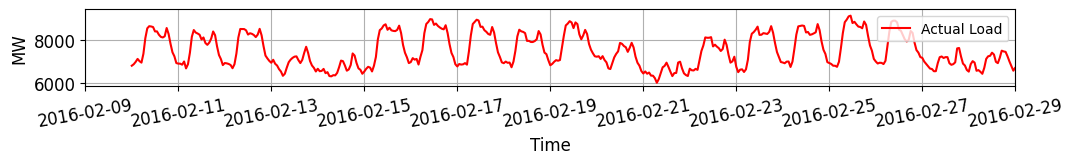

In [16]:
f = plt.figure(figsize=(12,1))
plt.plot(val_input_fold.iloc[:,0],c='r',label="Actual Load")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("MW", fontsize=12)
plt.xticks(fontsize=12,rotation=10)
plt.yticks(fontsize=12)
plt.xlim(16840,16860)
plt.show()
# f.savefig("./K-FOld/VAL_SET_2_OUTPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/VAL_SET_2_OUTPUT.png",format="png",dpi=300,bbox_inches="tight")

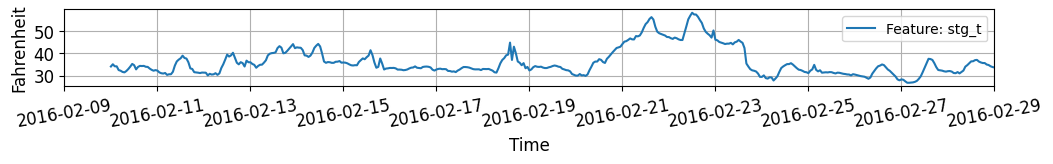

In [17]:
f = plt.figure(figsize=(12,1))
plt.plot(val_input_fold.iloc[:,7],label="Feature: stg_t")
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fahrenheit", fontsize=12)
plt.xticks(fontsize=12,rotation=10)
plt.yticks(fontsize=12)
plt.xlim(16840,16860)
plt.show()
# f.savefig("./K-FOld/VAL_SET_2_INPUT.svg",format="svg",dpi=300)
f.savefig("./K-FOld/VAL_SET_2_INPUT.png",format="png",dpi=300,bbox_inches="tight")